In [ ]:
!pip install geemap

import ee
import geemap
import pandas as pd
from matplotlib import pyplot


ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.0 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11124 sha256=47fd9fe6c366626990b1226c493e3b624c95b8f0f20336fafcad2e9e2d0dff13
  Stored

In [ ]:
#lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    #.filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))

data = pd.read_csv("Cayuga_Lake.csv", index_col=0, parse_dates=True)

In [ ]:
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174 entries, 2022-09-28 to 2017-06-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ChA     174 non-null    float64
dtypes: float64(1)
memory usage: 2.7 KB


,ChA
Sample Date,
2017-07-19,0.843
2017-07-19,0.247
2017-07-10,0.084
2017-07-05,0.191
2017-06-20,0.008


In [ ]:
#station = ee.Geometry.Point(-74.86113631486039,43.82283062049295)
station = ee.Geometry.Point(-76.67,42.63)
Map.addLayer(station)
Map.centerObject(station, 16)
Map

Map(center=[42.629999999999995, -76.67], controls=(WidgetControl(options=['position', 'transparent_bg'], widge…

In [ ]:
LC5_BANDS = ['SR_B1',   'SR_B2',    'SR_B3',  'SR_B4',  'SR_B5',    'SR_B7',    'ST_B6','QA_PIXEL']; #Llandsat 5
LC8_BANDS = ['SR_B2','SR_B3','SR_B4',  'SR_B5','SR_B6','SR_B7','ST_B10','QA_PIXEL']; #Landsat 8
STD_NAMES = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp','QA'];

In [ ]:
def cdom(img):
    co = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1' : img.select('blue'),
        'b2' : img.select('green'),
        'b3' : img.select('red'),
        'b4' : img.select('nir')
    }).rename("CO")
    return img.addBands([co])

# def threebda(img):
#   chA = img.expression("(blue.subtract(red).divide(blue.add(red)).subtract(green))", {
#       'blue' : img.select('blue'),
#       'green' : img.select('green'),
#       'red' : img.select('red'),

#   }).rename("Chlorophyll")

#   return img.addBands([chA])

def threebda(img):
  chA = img.expression("(((blue-red)/(blue+red))-green)", {
      'blue' : img.select('blue'),
      'green' : img.select('green'),
      'red' : img.select('red'),

  }).rename("Chlorophyll")

  return img.addBands([chA])

In [ ]:
# def threebdaL5(img):
#   red = img.select('B3')
#   green = img.select('SR_B2')
#   blue = img.select('SR_B1')
#   chA = img.expression(blue.subtract(red).divide(blue.add(red)).subtract(green).rename('Chlorophyll')).rename("CO")
#   return img.addBands([chA])

In [ ]:
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)

nlcd = ee.Image('USGS/NLCD/NLCD2016');
def waterMask1(image):
  waterMask = nlcd.select('landcover').eq(11);
  return image.updateMask(waterMask)

l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(5, 11, 'month')) \
   .filterBounds(station) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(waterMask1) \
   .map(maskL457sr) \
   .select(LC5_BANDS, STD_NAMES) \
   .map(threebda)

#l5 = l5.map(maskL457sr)

In [ ]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)
#only looking from May to November, hence 5 and 11
l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(station) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(waterMask1) \
    .map(maskL8sr) \
    .select(LC8_BANDS, STD_NAMES) \
    .map(threebda)


#l8 = l8


#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));

In [ ]:
# Define a polygon representing the extent of Cayuga Lake.
cayugaLake = ee.Geometry.Polygon([
  [-76.854, 42.777],  # Northwest corner
  [-76.854, 42.596],  # Southwest corner
  [-76.489, 42.596],  # Southeast corner
  [-76.489, 42.777]   # Northeast corner
]);

# Import the Landsat 8 TOA image collection.
#l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA');

# Set the date range around September 3, 2019.
#startDate = '2019-08-31'
#endDate = '2019-09-08'


In [ ]:
# # Get the least cloudy image within the date range and over Cayuga Lake.
# image = ee.Image(
#   l8.filterBounds(cayugaLake)
#     .filterDate(startDate, endDate)
#     .sort('CLOUD_COVER')
#     .first()
# )

# # Apply the cloud mask.
# def cloudMask(image):
#   clouds = ee.Algorithms.Landsat.simpleCloudScore(image).select('cloud')
#   maskedImage = image.updateMask(clouds.lt(20))
#   return maskedImage

# cloudMasked = cloudMask(image)

In [ ]:
# Load NLCD land cover data.
nlcd = ee.Image('USGS/NLCD/NLCD2016');

# Filter NLCD land cover image for open water (code 11).
#waterMask = nlcd.select('landcover').eq(11); # Water class (code 11)

# Apply the water mask to the chlorophyll image.
#chlMasked = lall.first().updateMask(waterMask);

# Display the result.
Map.centerObject(cayugaLake, 10);
#chlParams = {min: -1, max: 1, 'palette': ['blue', 'green', 'red']}
#Map.addLayer(chlMasked, chlParams, 'Chlorophyll image (Open Water Only)')
#Map

In [ ]:
def station_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).get('Chlorophyll')
    return img.set('date', img.date().format()).set('ChlA',mean)

In [ ]:
station_reduced_imgs = lall.map(station_mean)

In [ ]:
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','ChlA']).values().get(0)

In [ ]:
from ee.data import getInfo
getInfo

<function ee.data.getInfo(asset_id)>

In [ ]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','ChlA'])

df

,date,ChlA
0,1991-07-30T15:08:43,0.240493
1,1992-05-13T15:08:57,0.121123
2,1992-05-29T15:08:49,0.086716
3,1992-06-14T15:08:37,0.088791
4,1992-09-18T15:07:17,0.094113
5,1995-06-07T14:51:46,0.167877
6,1999-10-08T15:21:52,-0.031688
7,2002-06-10T15:21:37,0.223596
8,2003-06-29T15:21:23,0.300761
9,2004-10-05T15:29:31,0.029218


In [ ]:
df.sort_values('date', inplace=True)

# # Convert 'date' column in df(CDOM) to datetime dtype
# df['date'] = pd.to_datetime(df['date'])

df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,ChlA
0,1991-07-30,0.240493
1,1992-05-13,0.121123
15,1992-05-13,0.122392
24,1992-05-20,0.078611
2,1992-05-29,0.086716
16,1992-05-29,0.085578
3,1992-06-14,0.088791
17,1992-06-14,0.089114
4,1992-09-18,0.094113
5,1995-06-07,0.167877


In [ ]:
df = pd.DataFrame(nested_list.getInfo(), columns=['date','ChlA'])
pd.set_option('display.max_rows', None)
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date

df

,date,ChlA
0,1991-07-30,0.240493
1,1992-05-13,0.121123
2,1992-05-29,0.086716
3,1992-06-14,0.088791
4,1992-09-18,0.094113
5,1995-06-07,0.167877
6,1999-10-08,-0.031688
7,2002-06-10,0.223596
8,2003-06-29,0.300761
9,2004-10-05,0.029218


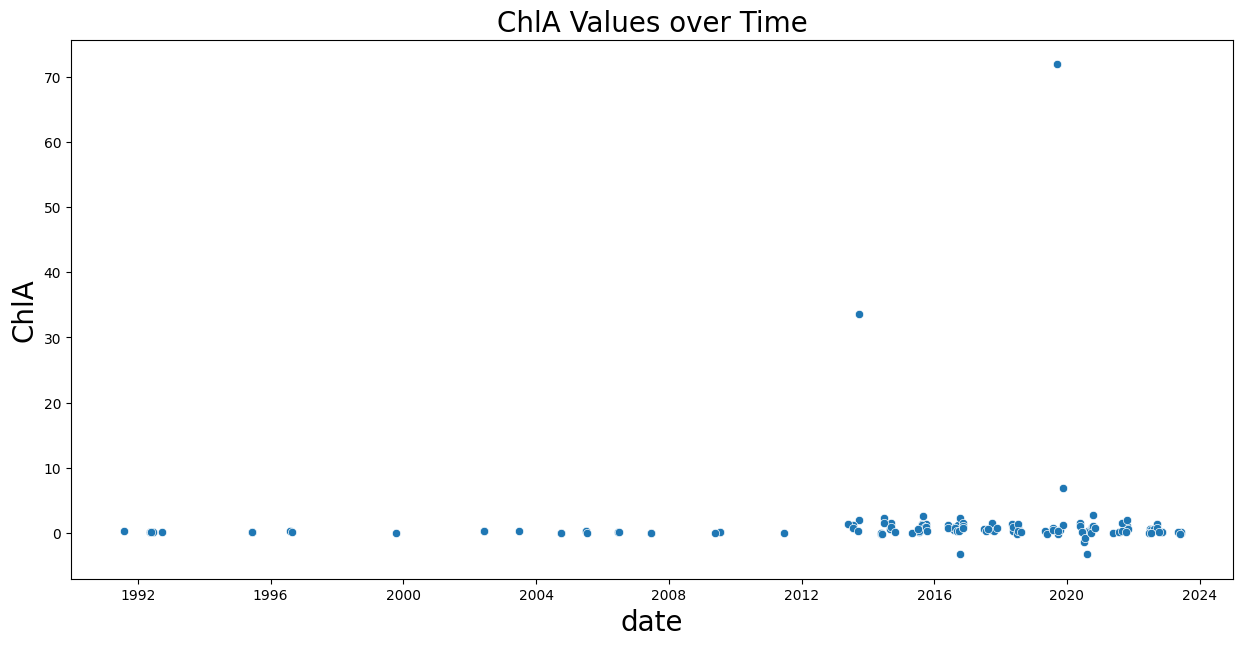

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='mean', ax=ax)

# Set the labels and title
ax.set_ylabel('ChlA', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('ChlA Values over Time', fontsize=20)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()

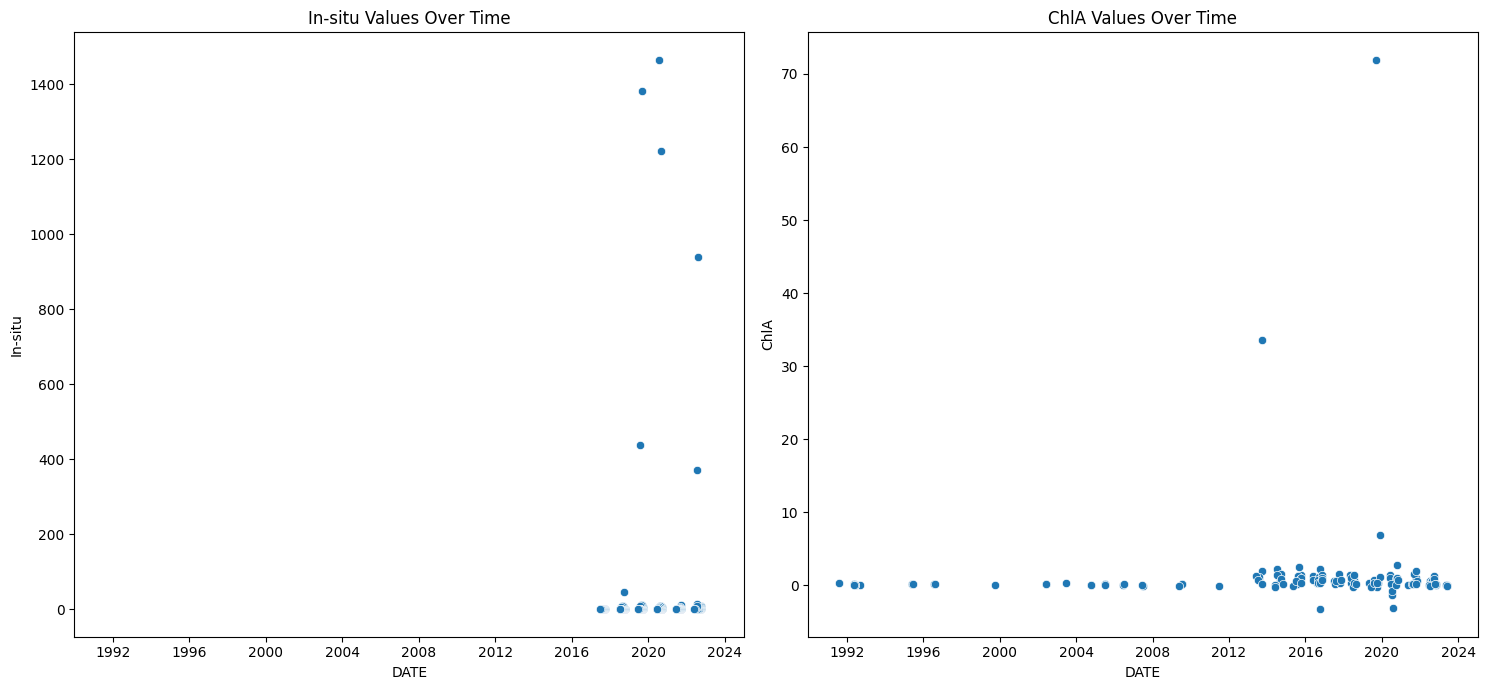

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Seaborn scatter plot
sns.scatterplot(data=data, x=data.index, y=data.ChA, ax=ax1)
ax1.set_xlabel('DATE')
ax1.set_ylabel('In-situ')
ax1.set_title('In-situ Values Over Time')

# Seaborn scatter plot
sns.scatterplot(data=df, x='date', y='ChlA', ax=ax2)
ax2.set_xlabel('DATE')
ax2.set_ylabel('ChlA')
ax2.set_title('ChlA Values Over Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Matplotlib scatter plot
ax.scatter(df['date'], df['mean'], label='CDOM')

# Matplotlib scatter plot
ax.scatter(data.index, data['DOC'], label='DOC')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('Values')
ax.set_title('CDOM vs DOC')

# Add a legend
ax.legend()

# Display the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plots
sns.scatterplot(data=df, x='date', y='mean', ax=ax, label='CDOM')
sns.scatterplot(data=data, x='DATE', y='DOC', ax=ax, label='DOC')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('Values')
ax.set_title('CDOM vs DOC')

# Add a legend
ax.legend()

# Display the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=df, x='date', y='mean', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data.index, data['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(6, 10)  # Adjust the range for CDOM
ax2.set_ylim(1, 9)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()